# Clustering Analysis (Birth Place Location)

## Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import sklearn
from sklearn.cluster import KMeans
import sklearn.metrics as sm
from sklearn import datasets
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import scale
from lat_lon_parser import parse
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline

## Import Excel Data

In [2]:
map = {}
xls = pd.ExcelFile('nba_draft.xlsx')
for sheet_name in xls.sheet_names:
    map[sheet_name] = xls.parse(sheet_name)

## Initialize Parameters

In [3]:
num_clusters = 5
max_draft_selection = 30
positions = ['Center', 'Point']
start_year = 1990
end_year = 2000
color_theme = np.array(['red','blue','green', 'yellow', 'orange', 'brown', 'purple', 'teal', 'dark blue', 'dark green'])

## Clean, Partition, Transform Data 

In [4]:
df = []
for i in range(start_year, end_year):
    df.append(map['draft_data_{}'.format(i)])
    
percentages_df = pd.concat(df)
percentages_df = percentages_df[percentages_df['Pk']  <= max_draft_selection]
loc_df = percentages_df.iloc[:, -2:]
loc_df = loc_df.dropna()
loc_df['bp_longitude'] = loc_df.bp_longitude.apply(lambda x: parse(x)) 
loc_df['bp_latitude'] = loc_df.bp_latitude.apply(lambda x: parse(x))  
loc_df_with_years = percentages_df.iloc[:, list(range(50,52)) + [-3]]
data = loc_df.to_numpy()
clustering  = KMeans(n_clusters=num_clusters,random_state=5)
clustering.fit(data)
loc_df.columns = ['Longitude','Latitude']

## Elbow Method

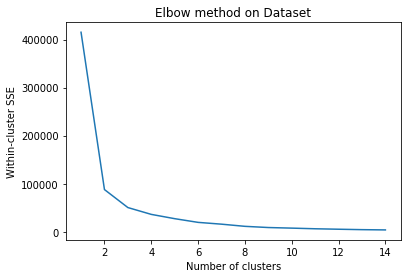

In [5]:
distortations = {}
for k in range(1,15):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(data)
  distortations[k] = kmeans.inertia_

plt.plot(list(distortations.keys()),list(distortations.values()))
plt.title('Elbow method on Dataset')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster SSE')
plt.show()

## Clustering Output (2D Plots)

Clusters: [[  36.99932483  -77.11075118]
 [  34.95437831   28.60366075]
 [  38.14435645 -117.71020388]
 [  37.72786487  -90.7634156 ]
 [ -24.7761086   134.755     ]]


red: Cluster 0
blue: Cluster 1
green: Cluster 2
yellow: Cluster 3
orange: Cluster 4


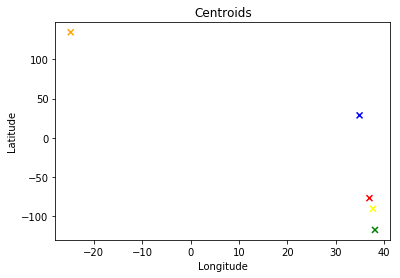

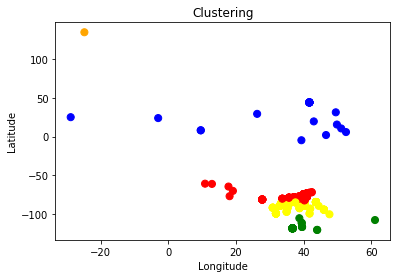

In [6]:
centroids = clustering.cluster_centers_
print('Clusters: {}'.format(centroids))
print('\n')
t = np.arange(num_clusters)
for i in range(len(centroids)):
    print('{}: Cluster {}'.format(color_theme[i], i))
    
plt.scatter(centroids[:,0], centroids[:,1], marker="x", c=color_theme[t])
plt.title('Centroids')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

plt.scatter(x=loc_df.Longitude,y=loc_df.Latitude,c=color_theme[clustering.labels_],s=50)
plt.title('Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

##  Clustering Output Aggregations

In [7]:
cluster_counts = {}
for i in range(len(clustering.labels_)):
    if clustering.labels_[i] not in cluster_counts:
        cluster_counts[clustering.labels_[i]] = 1
    else:
        cluster_counts[clustering.labels_[i]] += 1
print('Totals:')
for i in cluster_counts:
    print('{} players were drafted in the top {} picks of their respective draft that fall in cluster {}'.format(cluster_counts[i], max_draft_selection, i))
print('\n')
        
decade_counts = {1990: {}, 2000: {}, 2010: {}}
for i in range(num_clusters):  
    decade_counts[1990.0][i] = 0
    decade_counts[2000.0][i] = 0
    decade_counts[2010.0][i] = 0

for i in range(len(clustering.labels_)):
    if (1990.0 <= loc_df_with_years.iloc[i][2] < 2000.0):  
        decade_counts[1990][clustering.labels_[i]] += 1
    elif (2000.0 <= loc_df_with_years.iloc[i][2] < 2010.0):  
        decade_counts[2000][clustering.labels_[i]] += 1
    elif (2010.0 <= loc_df_with_years.iloc[i][2] < 2020.0):  
        decade_counts[2010][clustering.labels_[i]] += 1
    
for i in decade_counts:
    print('In the {}\'s'.format(i))
    for j in decade_counts[i]:
        print('     {} players were drafted in the top {} picks of their respective draft that fall in cluster {}'.format(decade_counts[i][j],max_draft_selection,  j))

Totals:
108 players were drafted in the top 30 picks of their respective draft that fall in cluster 3
38 players were drafted in the top 30 picks of their respective draft that fall in cluster 2
104 players were drafted in the top 30 picks of their respective draft that fall in cluster 0
23 players were drafted in the top 30 picks of their respective draft that fall in cluster 1
1 players were drafted in the top 30 picks of their respective draft that fall in cluster 4


In the 1990's
     104 players were drafted in the top 30 picks of their respective draft that fall in cluster 0
     23 players were drafted in the top 30 picks of their respective draft that fall in cluster 1
     38 players were drafted in the top 30 picks of their respective draft that fall in cluster 2
     108 players were drafted in the top 30 picks of their respective draft that fall in cluster 3
     1 players were drafted in the top 30 picks of their respective draft that fall in cluster 4
In the 2000's
     

##  Cluster Dendogram

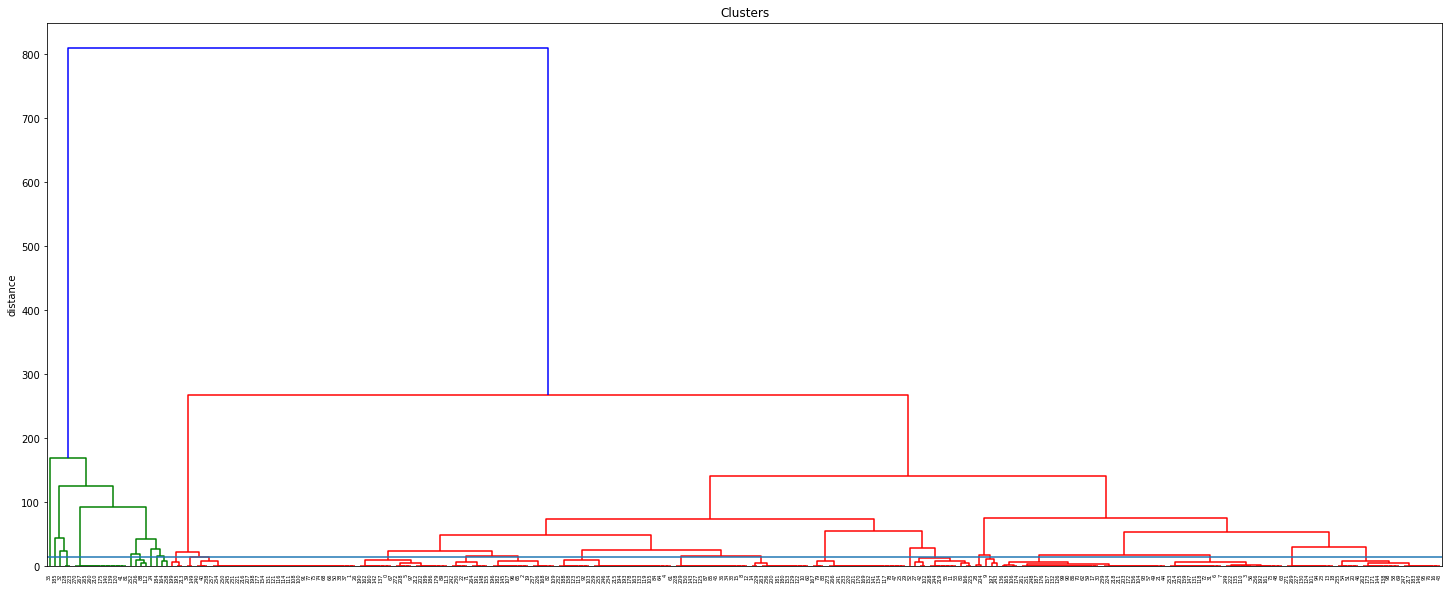

In [8]:
Z = linkage(data,'ward')

plt.figure(figsize=(25,10))
plt.title('Clusters')
plt.ylabel('distance')
dendrogram(Z)

plt.axhline(y=15)
plt.show()